<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/bt_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install
!pip install self_supervised
!pip install pytest
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 544 kB/s 
     |████████████████████████████████| 551 kB 8.2 MB/s 
     |████████████████████████████████| 548 kB 82.8 MB/s 
     |████████████████████████████████| 163 kB 86.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 298 kB 4.6 MB/s 
     |████████████████████████████████| 1.6 MB 89.5 MB/s 
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: pytest
    Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [ ]:
#import 
import fastai
import self_supervised
import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from torchvision import transforms
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

In [ ]:
#In this cell we get the data for MNIST (including some helpful functions we can potentially use
#to get CIFAR10 data etc)
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
#Base functions / classes we need to train a BT / RBT model.
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

def random_sinusoid(x,std=0.1,seed=0):
    
    seed_everything(seed=seed)    
    t=(std) * torch.randn(1,ps).to(device)
    s=(std) * torch.randn(1,ps).to(device)
    
    u=torch.randn(1,ps).to(device)
    v=torch.randn(1,ps).to(device)

    a=(0.2) * torch.randn(1,ps).to(device)
    b=(0.2) * torch.randn(1,ps).to(device)

    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,bs):
    
    Ctem1 =  (z1norm.T @ z2norm_2) / bs
    Ctem2 = (z1norm_2.T @ z2norm) / bs
    cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

    return cdiff_2

class Cdiff_Rand:
    
    def __init__(self,seed,bs,std=0.1,K=2):
        self.seed=seed
        self.std=std
        self.K=K
        self.bs=bs

    def __call__(self,z1norm,z2norm):
        
        cdiff_rand=0
        for i in range(self.K):

            z1norm_2,z2norm_2 = random_sinusoid(z1norm,std=self.std,seed=self.seed+i), random_sinusoid(z2norm,std=self.std,seed=2*self.seed+i)
            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)

        cdiff_rand=(1/self.K)*cdiff_rand
    
        return cdiff_rand

class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ps,ps)
        self.fc2 = nn.Linear(ps,ps)

        self.fc3 = nn.Linear(ps,ps)
        self.fc4 = nn.Linear(ps,ps)

        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU()
    def forward(self,x,y):

        x=self.sigmoid(self.fc1(x)) #when (sigmoid,relu) GREAT results, with (sigmoid,sigmoid) TERRIBLE. Currently testing (relu,relu)
        x=self.fc2(x)
       
        y=self.relu(self.fc3(y)) #originally had relu and got really good results. If we can't reproduce those results, possible reasons:
                                    #results were due to chance; or having relu on one branch (and sigmoid on the other) helps via breaking
                                      #the symmetry! Other idea: set fc1=fc3, fc2=fc4. 
        y=self.fc4(y)

        return x,y

class Cdiff_Sup:
    
    def __init__(self,I,inner_steps,bs):
        
        self.I=I
        self.inner_steps=inner_steps
        self.bs=bs
        self.max_corr = Max_Corr()
        if device == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        I=self.I
        bs=self.bs
        inner_steps=self.inner_steps

        z1norm=z1norm.detach()
        z2norm=z2norm.detach()

        # z1norm=z1norm[:,0]
        # z2norm=z2norm[:,0]

        max_corr = Max_Corr()
        max_corr.cuda()
    
        # for p in max_corr.parameters():
        #     p.requires_grad=True]

        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        for i in range(inner_steps):
            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            #z1norm_2 = (z1norm_2 - z1norm_2.mean(0)) / z1norm_2.std(0, unbiased=False)
        
            assert (z1norm_2.shape,z2norm_2.shape) == (z1norm.shape,z2norm.shape)

            # Ctem1 =  (z1norm.T @ z2norm_2) / bs
            # Ctem2 = (z1norm_2.T @ z2norm) / bs
            # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
            #cdiff_2=Ctem.pow(2)

            inner_loss=-1*(cdiff_2*(1-I)).mean()

            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
      
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
    
            return cdiff_sup

#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1

        self.inner_steps=4
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1

        if self.epoch%10==0:
            self.inner_steps += 1

        learn.export('model.pkl')

    def before_batch(self):
        xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()

        #Uncomment to run standard BT
    # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
    #     bs,nf = pred.size(0)//2,pred.size(1)

    #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
    #     C = (z1norm.T @ z2norm) / bs 
    #     cdiff = (C - self.I)**2
    #     loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
    #     return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2



        # #Let's change this block to rewritten (should do same thing)
        # max_corr = inner_step(z1norm,z2norm,I=self.I,inner_steps=5)#,inner_steps=self.inner_steps)
        # z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
        # Ctem1 =  (z1norm.T @ z2norm_2) / bs
        # Ctem2 = (z1norm_2.T @ z2norm) / bs
        # #Ctem = (z1norm_2.T @ z2norm_2) / bs
        # #cdiff_2 = Ctem.pow(2)
        # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2)) #+ 0.1*Ctem.pow(2)


        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
        cdiff_2 = CdiffSup(z1norm,z2norm)

        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        cdiff_2_2 = CdiffRand(z1norm,z2norm)

        cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum()
        torch.cuda.empty_cache()
        return loss

    @torch.no_grad()
    def show(self, n=1):
 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        #x1 = TensorImageBW(x1)
        #x2 = TensorImageBW(x2)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [ ]:
# #New idea

# #Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
# #Definition is straightforward:
# #https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
# class BarlowTwinsModel(Module):
#     """An encoder followed by a projector
#     """
#     def __init__(self,encoder,projector,projector2):self.encoder,self.projector,self.projector2 = encoder,projector,projector2
        
#     def forward(self,x): 
#         # print('BarlowTwinsModel...')
#         # print(x.shape)
#         # print('shape of x')
#         # input()

#         # print(self.encoder(x).shape)
#         # print('shape of encoder(x)')
#         # input()
#         # print(self.projector(self.encoder(x)).shape)
        
#         # input('shape of z')
#         tem = self.encoder(x)
        
#         return self.projector(tem),self.projector2(tem)
    
    
# #HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
# #function can be used by minimally passing a predefined encoder and the expected input channels.

# #In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
# #MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

# #Questions: Why torch.no_grad() when doing this?
# def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
#     "Create Barlow Twins model"
#     n_in  = in_channels(encoder)
#     with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
#     projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
#     apply_init(projector)
    
#     projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
#     apply_init(projector2)
    
#     return BarlowTwinsModel(encoder, projector,projector2)

# #export
# class BarlowTwins(Callback):
#     order,run_valid = 9,True
#     def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
#         assert_aug_pipelines(aug_pipelines)
#         self.aug1, self.aug2 = aug_pipelines
#         if print_augs: print(self.aug1), print(self.aug2)
#         store_attr('lmb')
#         self.index=-1

#         self.inner_steps=4
        
#     def before_fit(self): 
#         self.learn.loss_func = self.lf
#         nf = self.learn.model.projector[-1].out_features
#         self.I = torch.eye(nf).to(self.dls.device)

#     def update_seed(self):
        
#         indexmod=2
#         if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
#             self.seed = np.random.randint(0,10000)

#     def before_epoch(self):
#         self.index=-1

#         if self.epoch%10==0:
#             self.inner_steps += 1
            
#     def before_batch(self):
    
#         xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
#         self.learn.xb = (torch.cat([xi, xj]),)

#         self.index=self.index+1
#         self.update_seed()



#     #Uncomment to run standard BT
#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         #bs,nf = pred.size(0)//2,pred.size(1)
#         bs,nf = pred[0].size(0)//2,pred[0].size(1)
#         seed=self.seed

#         pred1=pred[0]
#         pred2=pred[0]

#         z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2

#         #Used to encode, primarily invariance
#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)


#         #Used to encode, primarily redundancy-reduction
#         z1_two,z2_two = pred2[:bs],pred2[bs:]
#         z1norm_two = (z1_two - z1_two.mean(0)) / z1_two.std(0, unbiased=False)
#         z2norm_two = (z2_two - z2_two.mean(0)) / z2_two.std(0, unbiased=False)

#         #The invariance term
#         Invar = (z1norm-z2norm).pow(2) #add to loss


#         #The redundancy reduction term
#         CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
#         cdiff = CdiffRand(z1norm_two,z2norm_two)

#         #New
#         CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
#         cdiff_2 = CdiffSup(z1norm_two,z2norm_two)

#         cdiff = 0.5*cdiff + 0.5*cdiff_2

#         redun_reduc = self.lmb*cdiff #add to loss

#         #The `make the reps different` term
#         C1 = (z1norm.T @ z1norm_two) / bs
#         C2 = (z2norm.T @ z2norm_two) / bs

#         cdiff1 = 0.5*C1.pow(2)
#         cdiff2 = 0.5*C2.pow(2)

#         cdiff = self.lmb*(cdiff1+cdiff2) #add to loss

#         #The `prevent collapse to zero` term. Unnecessary given independence?
#         relu = nn.ReLU()
#         eps=1e-7
#         #C = (z1norm.T @ z1norm) / bs

#         cdiffa=relu(1-(z1.var(0,unbiased=False)+eps).pow(0.5))
#         cdiffb=relu(1-(z1_two.var(0,unbiased=False)+eps).pow(0.5))

#         loss = (1/nf)*Invar.sum() + 0.5*(cdiffa + cdiffb).sum()+ (redun_reduc + cdiff).sum()
#         #loss = (1/nf)*Invar.sum() + (redun_reduc + cdiff).sum()


#         return loss


#     # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        
#     #     bs,nf = pred.size(0)//2,pred.size(1)

#     #     #All standard, from BT
#     #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
#     #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#     #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#     #     C = (z1norm.T @ z2norm) / bs 
#     #     cdiff = (C - self.I)**2



#     #     # #Let's change this block to rewritten (should do same thing)
#     #     # max_corr = inner_step(z1norm,z2norm,I=self.I,inner_steps=5)#,inner_steps=self.inner_steps)
#     #     # z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
#     #     # Ctem1 =  (z1norm.T @ z2norm_2) / bs
#     #     # Ctem2 = (z1norm_2.T @ z2norm) / bs
#     #     # #Ctem = (z1norm_2.T @ z2norm_2) / bs
#     #     # #cdiff_2 = Ctem.pow(2)
#     #     # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2)) #+ 0.1*Ctem.pow(2)


#     #     CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
#     #     cdiff_2 = CdiffSup(z1norm,z2norm)

#     #     CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
#     #     cdiff_2_2 = CdiffRand(z1norm,z2norm)

#     #     cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2
            
#     #     l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

#     #     loss = (cdiff*self.I + l2).sum()
#     #     torch.cuda.empty_cache()
#     #     return loss

#     @torch.no_grad()
#     def show(self, n=1):
 
#         bs = self.learn.x.size(0)//2
#         x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
#         #x1 = TensorImageBW(x1)
#         #x2 = TensorImageBW(x2)
#         idxs = np.random.choice(range(bs),n,False)
#         x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
#         x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
#         images = []a
#         for i in range(n): images += [x1[i],x2[i]]
#         return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [ ]:
#new cell - copy pasted new idea across

#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector,projector2):self.encoder,self.projector,self.projector2 = encoder,projector,projector2
        
    def forward(self,x): 
        # print('BarlowTwinsModel...')
        # print(x.shape)
        # print('shape of x')
        # input()

        # print(self.encoder(x).shape)
        # print('shape of encoder(x)')
        # input()
        # print(self.projector(self.encoder(x)).shape)
        
        # input('shape of z')
        tem = self.encoder(x)
        
        return self.projector(tem),self.projector2(tem)
    
    
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    return BarlowTwinsModel(encoder, projector,projector2)

#Similar to above. Simple API to make the BT model:

#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1

        self.inner_steps=4
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1

        if self.epoch%10==0:
            self.inner_steps += 1
            
    def before_batch(self):
    
        xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()



    #Uncomment to run standard BT
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        #bs,nf = pred.size(0)//2,pred.size(1)
        bs,nf = pred[0].size(0)//2,pred[0].size(1)
        seed=self.seed

        pred1=pred[0]
        pred2=pred[0]

        z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2

        #Used to encode, primarily invariance
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)


        #Used to encode, primarily redundancy-reduction
        z1_two,z2_two = pred2[:bs],pred2[bs:]
        z1norm_two = (z1_two - z1_two.mean(0)) / z1_two.std(0, unbiased=False)
        z2norm_two = (z2_two - z2_two.mean(0)) / z2_two.std(0, unbiased=False)

        #The invariance term
        Invar = (z1norm-z2norm).pow(2) #add to loss


        #The redundancy reduction term
        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        cdiff = CdiffRand(z1norm_two,z2norm_two)

        #New
        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
        cdiff_2 = CdiffSup(z1norm_two,z2norm_two)

        cdiff = 0.5*cdiff + 0.5*cdiff_2

        redun_reduc = self.lmb*cdiff #add to loss

        # #The `make the reps different` term
        # C1 = (z1norm.T @ z1norm_two) / bs
        # C2 = (z2norm.T @ z2norm_two) / bs
        
        # cdiff1 = 0.5*C1.pow(2)
        # cdiff2 = 0.5*C2.pow(2)

        # cdiff = self.lmb*(cdiff1+cdiff2) #add to loss

        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        cdiff1  = CdiffRand(z1norm,z1norm_two)
        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
        cdiff11 = CdiffSup(z1norm,z1norm_two)
        cdiff1 = 0.5*cdiff1 + 0.5*cdiff11

        # CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        # cdiff2  = CdiffRand(z2norm,z2norm_two)
        # CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
        # cdiff22 = CdiffSup(z2norm,z2norm_two)
        # cdiff2 = 0.5*cdiff2 + 0.5*cdiff22
        #cdiff = self.lmb*(0.5*cdiff1 + 0.5*cdiff2)
        cdiff = self.lmb*cdiff1

        # #The `prevent collapse to zero` term. Unnecessary given independence?
        # relu = nn.ReLU()
        # eps=1e-7
        # #C = (z1norm.T @ z1norm) / bs

        # cdiffa=relu(1-(z1.var(0,unbiased=False)+eps).pow(0.5))
        # cdiffb=relu(1-(z1_two.var(0,unbiased=False)+eps).pow(0.5))

        #loss = (1/nf)*Invar.sum() + 0.5*(cdiffa + cdiffb).sum()+ (redun_reduc + cdiff).sum()
        loss = (1/nf)*Invar.sum() + (redun_reduc + cdiff).sum()

        return loss


    # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        
    #     bs,nf = pred.size(0)//2,pred.size(1)

    #     #All standard, from BT
    #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
    #     C = (z1norm.T @ z2norm) / bs 
    #     cdiff = (C - self.I)**2


    #     # #Let's change this block to rewritten (should do same thing)
    #     # max_corr = inner_step(z1norm,z2norm,I=self.I,inner_steps=5)#,inner_steps=self.inner_steps)
    #     # z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
    #     # Ctem1 =  (z1norm.T @ z2norm_2) / bs
    #     # Ctem2 = (z1norm_2.T @ z2norm) / bs
    #     # #Ctem = (z1norm_2.T @ z2norm_2) / bs
    #     # #cdiff_2 = Ctem.pow(2)
    #     # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2)) #+ 0.1*Ctem.pow(2)


    #     CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs)
    #     cdiff_2 = CdiffSup(z1norm,z2norm)

    #     CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
    #     cdiff_2_2 = CdiffRand(z1norm,z2norm)

    #     cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2
            
    #     l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

    #     loss = (cdiff*self.I + l2).sum()
    #     torch.cuda.empty_cache()
    #     return loss

    @torch.no_grad()
    def show(self, n=1):
 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        #x1 = TensorImageBW(x1)
        #x2 = TensorImageBW(x2)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [ ]:
#Functions / classes we need to evaluate the encoder - i.e. train linear head on frozen rep and evaluate. 
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

def turnoffgrad_model(fastai_encoder):
    for p in fastai_encoder.parameters():
        p.requires_grad=False
        
    return fastai_encoder


def train_head(encoder_nograd,bs_tune,tune_seed=10): #The seed choses a different (20) samples for training the head. 2 of each class
    """Train head on a tune_set, chosen through given tune_seed for reproducibility if needed
    """
    
    zdim=1024
    head = LinearClassifier(zdim=zdim)
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    for epoch in range(600):
        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20.
                                        #Will need to fix this for CIFAR10 etc

        loss = criterion(head(encoder_nograd(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return head

@torch.no_grad()
def eval_head(head):
    """Evaluate the (typically trained) head on on the test set
    """

    num_correct=0
    for x,y in dls_test.train:

        ypred = head(encoder_nograd(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

def eval_encoder(encoder_nograd,tune_seed=10):
    """"Evaluate the encoder, which means to train and evaluate the head - basically wrap functions train_head
        and eval_head
    """
    head=train_head(encoder_nograd,bs_tune,tune_seed=tune_seed)
    pct_correct = eval_head(head)
    return pct_correct



In [ ]:
#Let's get CIFAR10 stuff now

seed=42
tune_seed=10
ts=30000
bs=1024
tune_s=10000
bs_tune=1024
bs_test=1024
num_tune = 5
num_test=5
size=128


path = untar_data(URLs.CIFAR)
items = get_image_files(path / "train")
random.seed(seed)
items=items.shuffle()

items1 = items[0:ts]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

items0 = items[ts:ts+tune_s] #get tune set from here
random.seed(tune_seed)
items0=items0.shuffle()
#items0=items0[0:bs_tune]


split = IndexSplitter(list(range(bs_tune*num_tune)))
tds_tune = Datasets(items0, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items0))
dls_tune = tds_tune.dataloaders(bs=bs_tune,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)



#split = IndexSplitter(list(range(bs_tune)))
#tds_tune = Datasets(items0, [PILImage.create, [parent_label, Categorize()]], splits=split(items0)) #Or do we want this?
#dls_tune = tds_tune.dataloaders(bs=bs_tune, after_item=[ToTensor(), IntToFloatTensor()], device=device)

items2 = items[ts+tune_s:ts+tune_s+bs_test*num_test]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
tds_test = Datasets(items2, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=bs_test,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

N=len(dls_tune.valid)*bs_tune 
assert N == len(dls_tune.valid_ds) #Check that the tune set (valid) is divided by the batch size
assert len(dls_tune.valid_ds) == num_tune*bs_tune

N=len(dls_test.train)*bs_test
assert N == len(dls_test.train_ds)


In [ ]:
# #In this cell we train BT / RBT and then evaluate

# # #Train BT / RBT 
ps=1024 
hs=ps
fastai_encoder = create_fastai_encoder(xresnet34(),pretrained=False,n_in=3)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=size, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, bw_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])
learn = Learner(dls, model ,cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(250)
  
# #Test performance of encoder
performance_dict={}
fastai_encoder.eval() 
encoder_nograd = turnoffgrad_model(fastai_encoder) 
for num in range(1):
    pct_correct = eval_encoder(encoder_nograd,tune_seed=tune_seed+num) 
    performance_dict[f'seed_{num}'] = pct_correct 

print(torch.mean(tensor(list(performance_dict.values()))))  
performance_dict

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


epoch,train_loss,valid_loss,time
0,2041.988647,None,00:30
1,1733.510010,None,00:29
2,1477.419312,None,00:29
3,1244.701294,None,00:29
4,1063.375244,None,00:29
5,907.823730,None,00:29
6,768.882385,None,00:29
7,654.636353,None,00:29
8,579.379822,None,00:29
9,521.710571,None,00:29


tensor(0.5275)


{'seed_0': TensorCategory(0.5275)}

In [ ]:
#BT, 500 epochs
{'seed_0': TensorCategory(0.5041)} 

#RBT, 250 epochs (which was better than 100 epochs)
{'seed_0': TensorCategory(0.5172)}   

#"New idea:, 250 epochs
{'seed_0': TensorCategory(0.5275)}


/tmp/tmpdj8dc84n


TypeError: ignored

Comments:

Below we have some tests and example of augmentations used:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


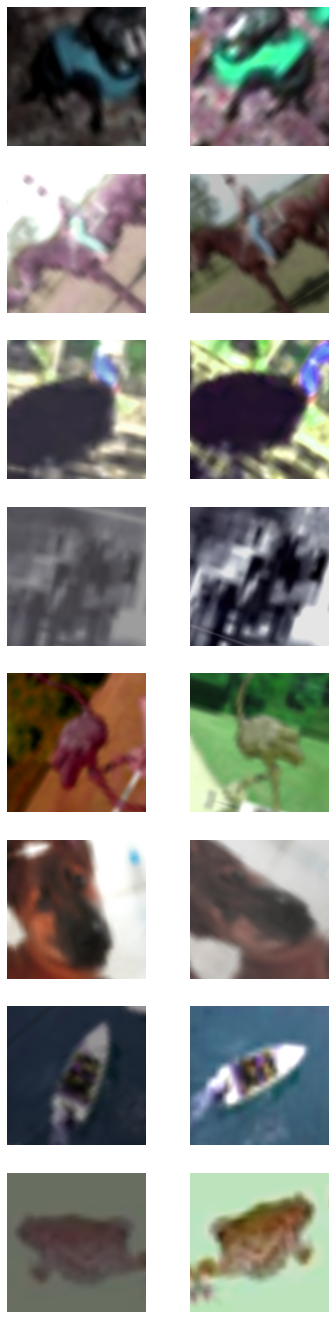

In [ ]:
#In this cell we display the augmentations used. 
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=3)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#aug_pipelines = get_barlow_twins_
#aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#aug_pipelines = get_barlow_twins_aug_pipelines(size=32, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=90, jitter_s=0.7, blur_s=(4, 8), same_on_batch=False, flip_p=0.5, rotate_p=0.5, jitter_p=0.5, bw_p=1.0, blur_p=0.5, cuda=True, xtra_tfms=[])

aug_pipelines = get_barlow_twins_aug_pipelines(size=140, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, bw_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])


learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=8)